In [1]:
# Import QICK libraries and extras

from qick import *

from tqdm import tqdm

import numpy as np
from numpy.fft import fft, fftshift

#%pylab inline
%matplotlib inline
import matplotlib.pyplot as plt
from qick.rfboard import RFQickSoc216V1


In [2]:
# from qick.pyro import make_proxy
# soc, soccfg = make_proxy(ns_host="pynq216-3.dhcp.fnal.gov", ns_port=8888, proxy_name="myqick")
# print(soccfg)

soc = RFQickSoc216V1('../firmware/qick_rf216_v2.bit', clk_output=None)
soccfg = soc

print(soccfg)


QICK running on ZCU216, software version 0.2.289

Firmware configuration (built Wed Jan 31 08:18:41 2024):

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	16 signal generator channels:
	0:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 0, blk 0 is 0_228, on JHC1
	1:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 0, blk 1 is 1_228, on JHC2
	2:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 0, blk 2 is 2_228, on JHC1
	3:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 0, blk 3 is 3_228, on JHC2
	4:	axis_sg_int4_v1 - envelope memory 4096 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 16-bit DDS, 

### general notes
* In this firmware, generator numbers map directly to front-panel DAC port numbers. (This is not a fundamental rule, and we will eventually put the front-panel port numbers next to the JHC port numbers in the soccfg printout.)
* In this firmware, readouts 4-7 map to front-panel ADC ports 0-3; readouts 0-3 are multiplexed onto front-panel ADC port 4.
* In this firmware, the digital output pins from the tProc map to the first four User I/O SMA ports.

## Set RFBoard Attenuation

In [3]:
ch_config = {"res_ch"      : 15, #specialized MUX gen
        "q1_ch"       : 4,
        "q2_ch"       : 5,
        "q3_ch"       : 6,
        "q4_ch"       : 7,
        "ro_ch"       :[0, 1, 2, 3], #array of 4 ro channels (0-3)
            }

#qcenter_filter = [4810, 4710, 4551, 4720] #MHz #4708
qcenter_filter = [4909, 4749, 4569, 4759]

########################
### RF Board Setting ###
########################

#######
# DAC #
#######
freq = 6000 # Center of band pass filter, with bandwidth 1 GHz

# Set Filter.
soc.rfb_set_gen_filter(ch_config['res_ch'], fc=freq/1000, ftype='bandpass') #fc in GHz
#soc.rfb_set_gen_filter(config['gen_ch'], fc=2.5, ftype='lowpass')

soc.rfb_set_gen_filter(ch_config['q1_ch'], fc=qcenter_filter[0]/1000, ftype='bandpass')
soc.rfb_set_gen_filter(ch_config['q2_ch'], fc=qcenter_filter[1]/1000, ftype='bandpass')
soc.rfb_set_gen_filter(ch_config['q3_ch'], fc=qcenter_filter[2]/1000, ftype='bandpass')
soc.rfb_set_gen_filter(ch_config['q4_ch'], fc=qcenter_filter[3]/1000, ftype='bandpass')

#set bandpass filter at where you know the qubit frequency is


# Set attenuator on DAC.
soc.rfb_set_gen_rf(ch_config['res_ch'], 8, 30)#25, 20)
# soc.rfb_set_gen_rf(ch_config['res_ch'], 8, 30)#25, 20)
soc.rfb_set_gen_rf(ch_config['q1_ch'], 5,5) # spec params are 20,15 for all 4 qubits
soc.rfb_set_gen_rf(ch_config['q2_ch'], 5,5) #(5,5)
soc.rfb_set_gen_rf(ch_config['q3_ch'], 5,5)
soc.rfb_set_gen_rf(ch_config['q4_ch'], 5,5) #(5,5)

#######
# ADC #
#######
# Set Filter.
soc.rfb_set_ro_filter(ch_config['ro_ch'][0], fc=freq/1000, ftype='bandpass')

# Set attenuator on ADC.
soc.rfb_set_ro_rf(ch_config['ro_ch'][0], 25)

# Time of flight (decimated loopback)

In [4]:
class MuxSGTest(AveragerProgram):
    def initialize(self):
        # Set up the multiplexed readout DAC.        
        self.declare_gen(ch=self.cfg["res_ch"], nqz=self.cfg['gen_nqz'],
                         mux_freqs = self.cfg['pulse_freqs'],
                         mux_gains = self.cfg['mux_gains'])     

        # DAC channel.
        length = self.us2cycles(self.cfg['pulse_length'], gen_ch=self.cfg['res_ch'])
        self.set_pulse_registers(ch = self.cfg['res_ch'], style = 'const', length=length, mask=[0,1,2,3])

        # Readout.
        for i in range(0,4):
            self.declare_readout(ch      = self.cfg['ro_ch'][i], 
                                 length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch'][i]),
                                 freq    = self.cfg['pulse_freqs'][i],
                                 gen_ch  = self.cfg['res_ch'])
    
        self.synci(200)  # give processor some time to configure pulses
        
    
    def body(self):       
        self.measure(pulse_ch        = self.cfg['res_ch'], 
                 adcs            = self.ro_chs, #self.cfg['ro_ch'],
                 adc_trig_offset = self.us2cycles(self.cfg['ro_offset'], ro_ch = self.cfg['ro_ch'][0]),
                 wait=True,
                 syncdelay       = self.us2cycles(self.cfg["relax_delay"]),
                 pins            = [0],
                 )

In [5]:
fcenter = [6187.1, 5828.32, 6600, 5959.25] #[6600, 5828.32, 6074.51, 5959.25] #[6187.1, 5827.6, 6074, 5958.5] #MHz

readout_cfg={
        "ro_length"   : 1, #4.7, #us    
        "ro_offset"   : 0.4, #0.5, #us
        "gen_nqz"     : 2, 
        "pulse_length": 0.5, #4.7, #us
        "mux_gains"  : [1, 1, 0, 1], #[0.85, 0.85, 0.85,0.85],# 0.5,1,1,1], #array of 4 gains - 1 is max output (range 0-1, fraction of max power)
       "pulse_freqs"  : fcenter,
        }

expt_cfg={"reps":1, 
          "soft_avgs": 1000, # Number of repetitions
          "relax_delay":20,
         }

config={**readout_cfg,**expt_cfg,**ch_config}

print(config)

{'ro_length': 1, 'ro_offset': 0.4, 'gen_nqz': 2, 'pulse_length': 0.5, 'mux_gains': [1, 1, 0, 1], 'pulse_freqs': [6187.1, 5828.32, 6600, 5959.25], 'reps': 1, 'soft_avgs': 1000, 'relax_delay': 20, 'res_ch': 15, 'q1_ch': 4, 'q2_ch': 5, 'q3_ch': 6, 'q4_ch': 7, 'ro_ch': [0, 1, 2, 3]}


In [6]:
# Run the script
tof=MuxSGTest(soccfg, config)
iq_list = tof.acquire_decimated(soc)

The readout at 6600.000 MHz may see some crosstalk from the tone at 5828.320 MHz.
The readout at 5828.320 MHz may see some crosstalk from the tone at 6600.000 MHz.
The readout at 5959.250 MHz may see some crosstalk from the tone at 6187.100 MHz.
The readout at 5828.320 MHz may see some crosstalk from the tone at 5959.250 MHz.


  0%|          | 0/1000 [00:00<?, ?it/s]

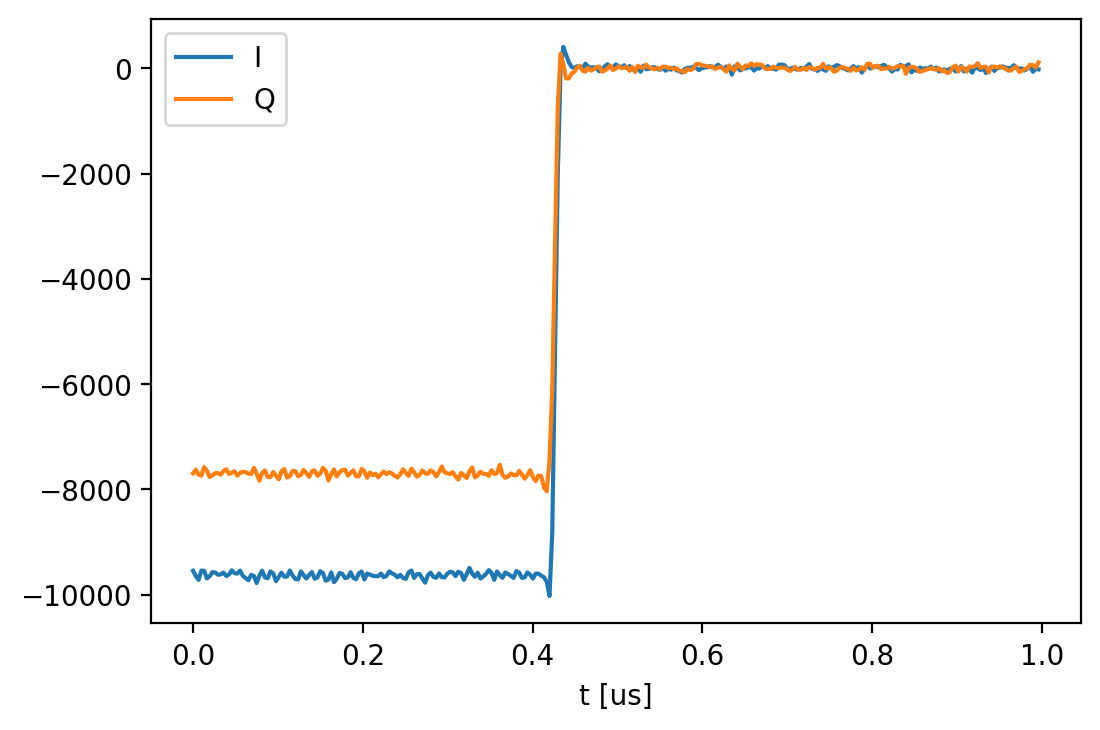

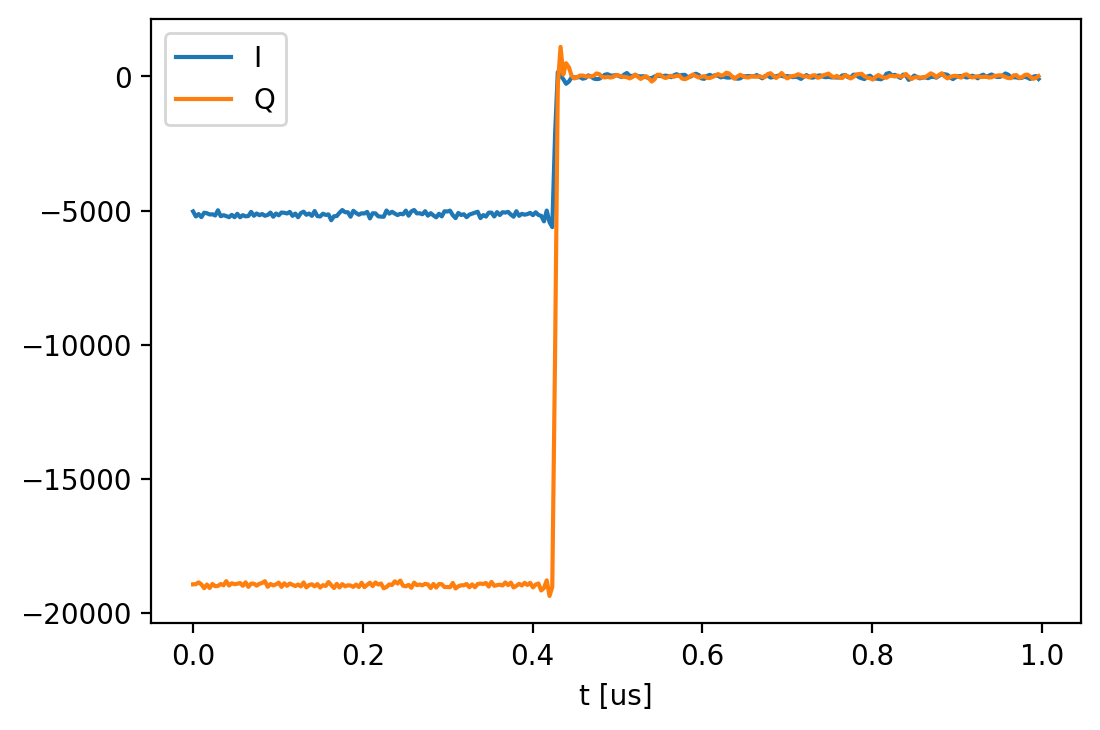

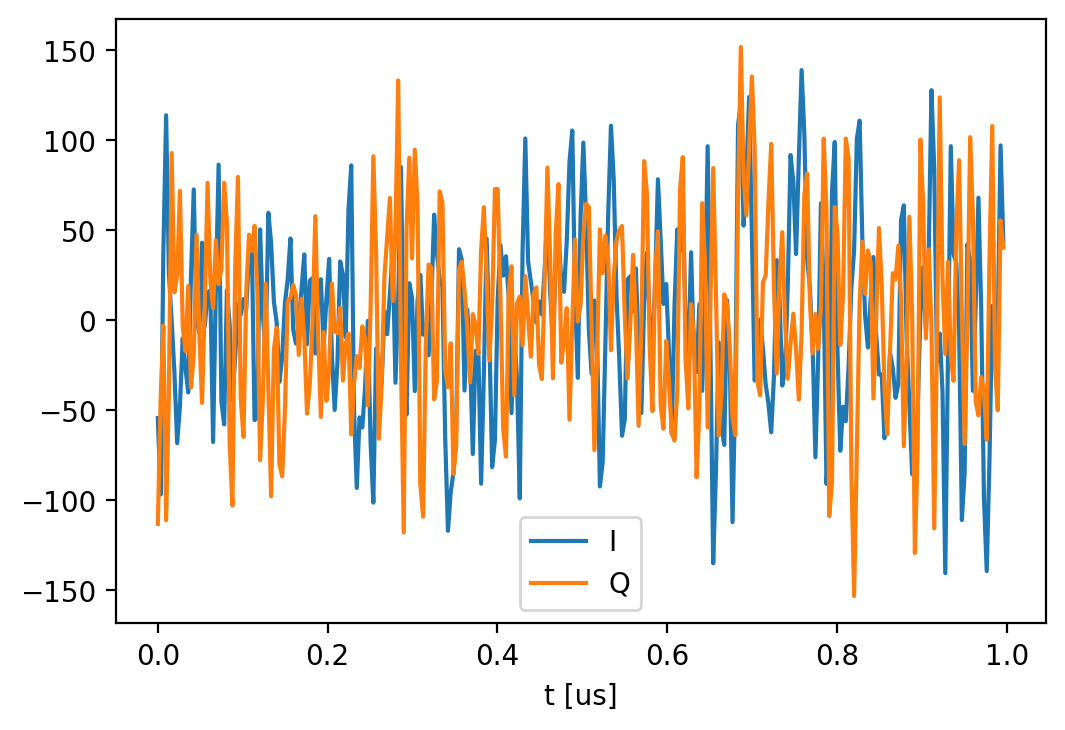

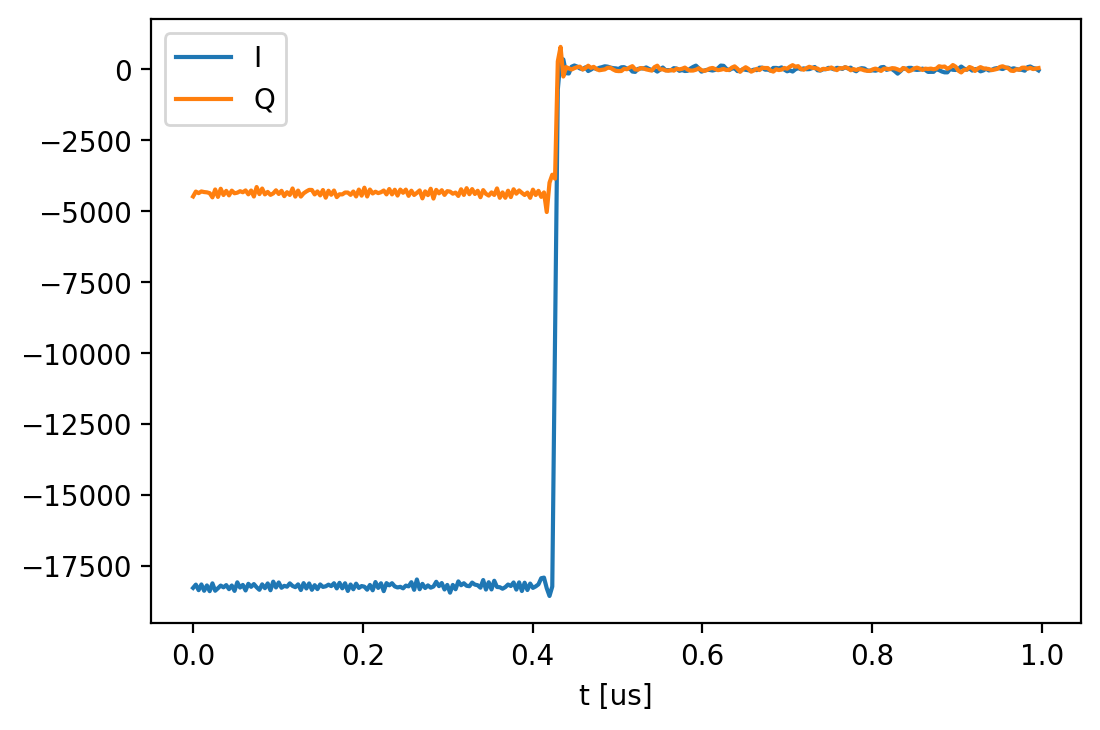

In [7]:
# Plot Captured Data.
plt.figure(dpi=200)

yi = iq_list[0][0]
yq = iq_list[0][1]
t = soccfg.cycles2us(ro_ch=config['ro_ch'][0], cycles=np.arange(len(iq_list[0][0])))

plt.plot(t,yi)
plt.plot(t,yq)
    
plt.xlabel('t [us]');
plt.legend(['I','Q']);


# Plot Captured Data.
plt.figure(dpi=200)

yi = iq_list[1][0]
yq = iq_list[1][1]
t = soccfg.cycles2us(ro_ch=config['ro_ch'][0], cycles=np.arange(len(iq_list[0][0])))

plt.plot(t,yi)
plt.plot(t,yq)
    
plt.xlabel('t [us]');
plt.legend(['I','Q']);


# Plot Captured Data.
plt.figure(dpi=200)

yi = iq_list[2][0]
yq = iq_list[2][1]
t = soccfg.cycles2us(ro_ch=config['ro_ch'][0], cycles=np.arange(len(iq_list[0][0])))

plt.plot(t,yi)
plt.plot(t,yq)
    
plt.xlabel('t [us]');
plt.legend(['I','Q']);


# Plot Captured Data.
plt.figure(dpi=200)

yi = iq_list[3][0]
yq = iq_list[3][1]
t = soccfg.cycles2us(ro_ch=config['ro_ch'][0], cycles=np.arange(len(iq_list[0][0])))

plt.plot(t,yi)
plt.plot(t,yq)
    
plt.xlabel('t [us]');
plt.legend(['I','Q']);

In [8]:
## Questions to work on

## With DAC attenuation of (8,30) + 40 dB attenuation, we see +/-3000 for signal and for noise
## With DAC attenuation of (8,10) + 40 dB attenuation, we see the edge of the pulse with 5000 averages.
## At NEXUS I'm concerned that our situation is actually like (8,30) + 20 dB attenuation (worst case fridge)
## and that we are saturating the ADC side of the RF board.

## 
## What does the FFT look like? 
## What is the "danger zone" as far as the settings for the DAC and ADC side attenuation?
## In this firmware, the digital output pins from the tProc map to the first four User I/O SMA ports. 


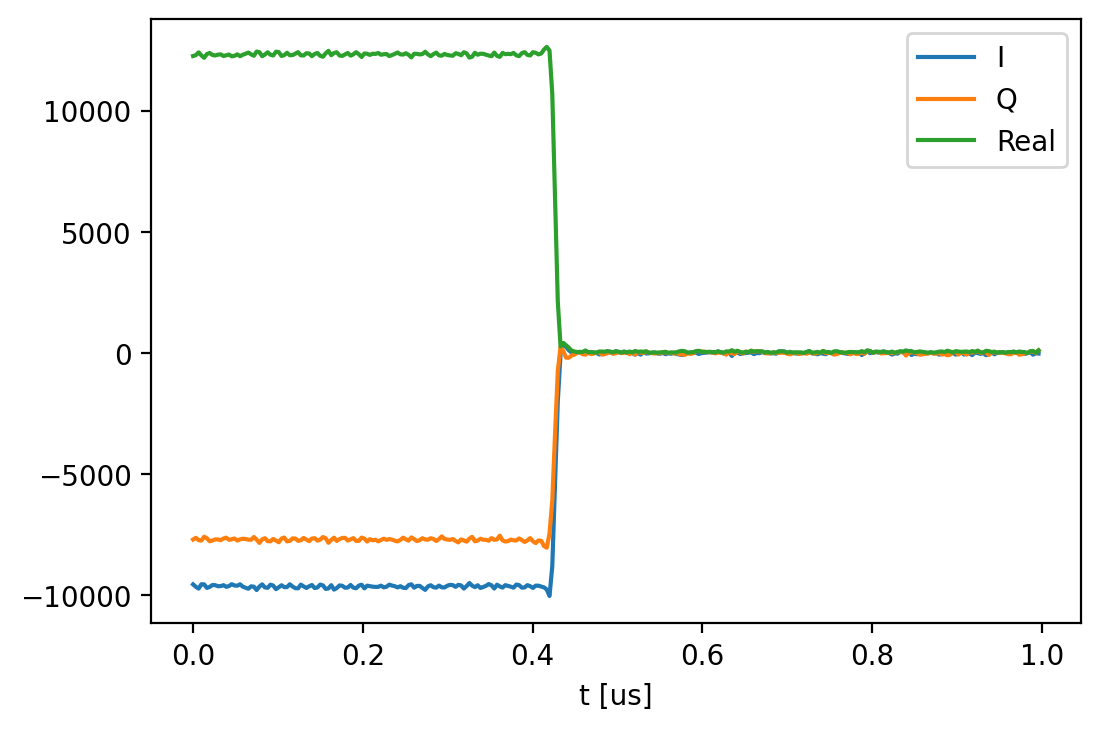

In [9]:
# Plot Captured Data.
plt.figure(dpi=200)

yi = iq_list[0][0]
yq = iq_list[0][1]
t = soccfg.cycles2us(ro_ch=config['ro_ch'][0], cycles=np.arange(len(iq_list[0][0])))

yr=np.sqrt(yi**2 + yq**2)


plt.plot(t,yi)
plt.plot(t,yq)
plt.plot(t,yr)
    
plt.xlabel('t [us]');
plt.legend(['I','Q','Real']);


(0.0, 1228.8)

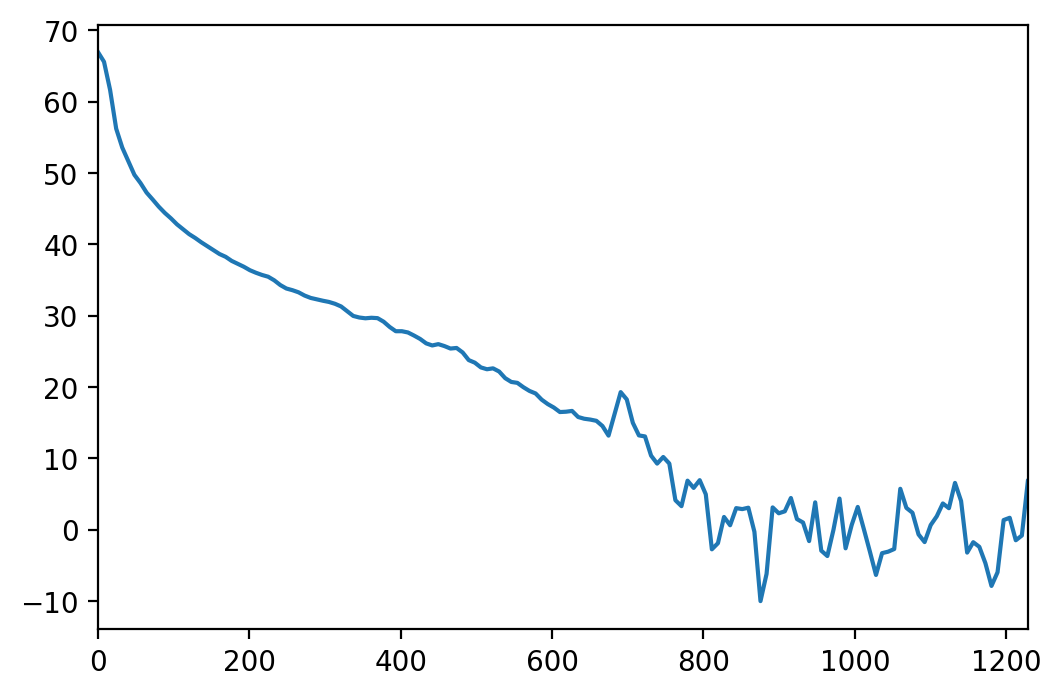

In [10]:
# Get data.
fs = 122.88*20
plt.figure(dpi=200)
x = yr

# Spectrum.
#x=x[1000:]
w = np.hanning(len(x))
xw = x*w
Y = fft(xw)/len(x)
YdB = 20*np.log10(np.abs(Y))
F = np.linspace(0,fs,len(Y))

#idx = np.argwhere((900 < F) & (F < 1100))
#minY = max(YdB[idx])
#maxY = max(YdB)
#snr = maxY - minY[0]
#print("SNR = {} dB".format(snr))

#plt.plot(F, 20*np.log10(np.abs(Y)/max(np.abs(Y))));
plt.plot(F, YdB);
#plt.plot(F, minY*np.ones(len(F)));
#plt.plot(F, maxY*np.ones(len(F)));
plt.xlim([0,fs/2])
#plt.ylim([-50,10]);
#plt.ylim([0,30]);